<a href="https://colab.research.google.com/github/remi-vidal/NLP-ensae/blob/main/notebook_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
<h1><center><strong><font color="chillipepper">Natural Language Processing - ENSAE 2022</font></strong></center></h1>
<h2><center><strong><font color="chillipepper">Poetry Analysis and Generation</font></strong></center></h2>

---

**Authors :** Louis AMRANI (louis.amrani@ensae.fr) and Rémi VIDAL (remi.vidal@ensae.fr)



Overview
...

# Imports and Installation

In [7]:
!pip install datasets torchinfo

     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 50.7 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 212 kB 48.3 MB/s 
     |████████████████████████████████| 136 kB 53.7 MB/s 
     |████████████████████████████████| 127 kB 60.1 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 51.1 MB/s 
     |████████████████████████████████| 271 kB 49.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import Counter
import datasets
from nltk.tokenize import TreebankWordTokenizer, ToktokTokenizer
from tqdm.notebook import tqdm

url = "https://raw.githubusercontent.com/remi-vidal/NLP-ensae/main/df_cleaned.csv"
df = pd.read_csv(url, index_col=0)

In [2]:
df.head()

title                 author  \
0   A Lonely Heart In A Thunderstorm          sylviaspencer   
1                   A Lonely Weekend          sylviaspencer   
2                 Lonely In The Dark             nouriblack   
3                      Lonely Burial  Stephen Vincent Benet   
4  Filmscript For A Lonely Afternoon       Michael Shepherd   

                                             content   theme  \
0  A lonely heart sets the table but is she a Mil...  lonely   
1  How bright it is on a Friday, when I am away f...  lonely   
2  I am living in the darkness\nI feel so scared\...  lonely   
3  There were not many at that lonely place,\nWhe...  lonely   
4  walks into deserted playground\nindifferently,...  lonely   

                                          file_title  
0  LonelyPoemsALonelyHeartInAThunderstormPoembysy...  
1   LonelyPoemsALonelyWeekendPoembysylviaspencer.txt  
2     LonelyPoemsLonelyInTheDarkPoembynouriblack.txt  
3  LonelyPoemsLonelyBurialPoembyStephenVincentBen...  
4  LonelyPoemsFilmscriptForALonelyAfternoonPoemby...

# Data Exploration

In [ ]:
df.columns

Index(['title', 'author', 'content', 'theme', 'file_title'], dtype='object')

In [ ]:
len(df)

14335

### Sanity check

In [ ]:
#Empty cells
for column in df.columns :
    print(df[column].isna().sum())

0
1
0
0
0


In [ ]:
# No NaN, except one author. Let's find it :
df[df['author'].isna()]

title author  \
12757  F Silent Fire    NaN   

                                                 content theme  \
12757  Tell me which fight do you fight deep in you\n...  fire   

                           file_title  
12757  FirePoemsFSilentFirePoemby.txt

$\longrightarrow$ The author was missing in the file name. Cannot retrieve it on internet (unknown author probably).

In [ ]:
# Number of different poems in the database
for column in ['title', 'content', 'file_title'] :
    print(len(df[column].unique()))

11665
13737
14335


$\longrightarrow$ No duplicate files in our database, but some poems are affected to several themes. For example :

In [ ]:
df[df['title']== 'The Sick Rose']

title         author  \
147  The Sick Rose  William Blake   
290  The Sick Rose  William Blake   

                                               content theme  \
147  O Rose, thou art sick!\nThe invisible worm\nTh...  rose   
290  O Rose, thou art sick!\nThe invisible worm\nTh...  sick   

                                     file_title  
147  RosePoemsTheSickRosePoembyWilliamBlake.txt  
290  SickPoemsTheSickRosePoembyWilliamBlake.txt

Moreover, some contents have several titles :

In [ ]:
df[df['content'] == (df[df['title'] == 'Personal Identity']['content'].values[0])]

title             author  \
842  Personal Identity As  Hasmukh Amathalal   
895     Personal Identity  Hasmukh Amathalal   

                                               content     theme  \
842  Personal identity\nWomen always need attention...  identity   
895  Personal identity\nWomen always need attention...  identity   

                                            file_title  
842  IdentityPoemsPersonalIdentityAsPoembyHasmukhAm...  
895  IdentityPoemsPersonalIdentityPoembyHasmukhAmat...

### Themes

In [ ]:
print("There are {} different themes in the database :".format(len(df['theme'].unique())))
df['theme'].unique()

There are 144 different themes in the database :


array(['lonely', 'rose', 'sick', 'carpe diem', 'hope', 'home', 'sorrow',
       'future', 'identity', 'passion', 'girl', 'butterfly', 'childhood',
       'memory', 'poem', 'sea', 'greed', 'baby', 'red', 'rainbow',
       'beauty', 'green', 'travel', 'power', 'family', 'evil', 'fear',
       'dark', 'dream', 'soldier', 'beautiful', 'city', 'laughter',
       'lost', 'spring', 'nature', 'sky', 'work', 'june', 'world',
       'racism', 'courage', 'faith', 'chicago', 'justice', 'school',
       'warning', 'happy', 'football', 'death', 'wedding', 'friend',
       'animal', 'culture', 'truth', 'trust', 'silver', 'heaven',
       'poetry', 'birth', 'father', 'january', 'pink', 'swimming',
       'paris', 'marriage', 'hero', 'river', 'money', 'son', 'mother',
       'frog', 'romance', 'crazy', 'joy', 'success', 'loss', 'daughter',
       'sympathy', 'thanks', 'dance', 'funeral', 'lust', 'hair', 'hate',
       'cinderella', 'car', 'peace', 'freedom', 'winter', 'song',
       'running', 'childre

In [ ]:
df['theme'].value_counts()

friend     100
rain       100
lust       100
brother    100
romance    100
          ... 
courage     98
anger       98
sea         98
sister      98
chicago     98
Name: theme, Length: 144, dtype: int64

In [ ]:
df['theme'].value_counts().value_counts()

100    90
99     43
98     11
Name: theme, dtype: int64

$\longrightarrow$ The poems are well distributed within the classes.

### Authors

In [ ]:
print("There are {} different authors in the database.".format(len(df['author'].unique())))

There are 4222 different authors in the database.


<AxesSubplot:>

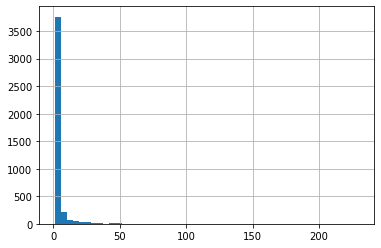

In [ ]:
#Histogram of the number of poems written per author
df['author'].value_counts().hist(bins = 50)

In [ ]:
#Let's print the top twenty : 
df['author'].value_counts()[:20]

Emily Dickinson                   230
johntiongchunghoo                 158
Michael Shepherd                  142
Francis Duggan                    141
Hasmukh Amathalal                 132
Dr A Celestine Raj Manohar M D    114
Aldo Kraas                        113
William Butler Yeats              108
David Harris                      107
Gajanan Mishra                    106
Herbert Nehrlich                  105
Lovina Sylvia Chidi                99
R I C B A S T A S A                95
C J Heck                           89
D+¦nall Dempsey                    85
Uriah Hamilton                     79
Robert William Service             72
Walt Whitman                       68
Robert Louis Stevenson             62
William Blake                      61
Name: author, dtype: int64

### Titles and content

<AxesSubplot:>

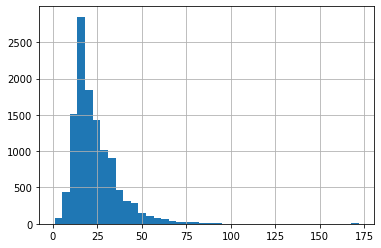

In [ ]:
df.title.drop_duplicates().apply(len).hist(bins=40)

In [ ]:
# let's add some basic information about the text: number of "words" (here we only split by a space, a really naive approach)
df['title_len'] = df.title.apply(lambda x: len(x.split(' ')) )
df['content_len'] = df.content.apply(lambda x: len(x.split(' ')) )

In [ ]:
df

title                 author  \
0       A Lonely Heart In A Thunderstorm          sylviaspencer   
1                       A Lonely Weekend          sylviaspencer   
2                     Lonely In The Dark             nouriblack   
3                          Lonely Burial  Stephen Vincent Benet   
4      Filmscript For A Lonely Afternoon       Michael Shepherd   
...                                  ...                    ...   
14330                          War Music         Henry Van Dyke   
14331                              Music     Rainer Maria Rilke   
14332                 The Sound Of Music        Ravi Sathasivam   
14333                         Reed Music       Frederick Kesner   
14334                              Music           Wilfred Owen   

                                                 content   theme  \
0      A lonely heart sets the table but is she a Mil...  lonely   
1      How bright it is on a Friday, when I am away f...  lonely   
2      I am living in the darkness\nI feel so scared\...  lonely   
3      There were not many at that lonely place,\nWhe...  lonely   
4      walks into deserted playground\nindifferently,...  lonely   
...                                                  ...     ...   
14330  Break off! Dance no more!\nDanger is at the do...   music   
14331  Take me by the hand;\nit's so easy for you, An...   music   
14332  The sound of music gives us so much emotions\n...   music   
14333  Amber frosted reeds\nin the summer's wind\nswa...   music   
14334  I have been urged by earnest violins\nAnd drun...   music   

                                              file_title  title_len  \
0      LonelyPoemsALonelyHeartInAThunderstormPoembysy...          6   
1       LonelyPoemsALonelyWeekendPoembysylviaspencer.txt          3   
2         LonelyPoemsLonelyInTheDarkPoembynouriblack.txt          4   
3      LonelyPoemsLonelyBurialPoembyStephenVincentBen...          2   
4      LonelyPoemsFilmscriptForALonelyAfternoonPoemby...          5   
...                                                  ...        ...   
14330           MusicPoemsWarMusicPoembyHenryVanDyke.txt          2   
14331          MusicPoemsMusicPoembyRainerMariaRilke.txt          1   
14332  MusicPoemsTheSoundOfMusicPoembyRaviSathasivam.txt          4   
14333       MusicPoemsReedMusicPoembyFrederickKesner.txt          2   
14334               MusicPoemsMusicPoembyWilfredOwen.txt          1   

       content_len  
0              177  
1              169  
2              198  
3              100  
4                9  
...            ...  
14330          302  
14331           51  
14332          143  
14333           23  
14334          104  

[14335 rows x 7 columns]

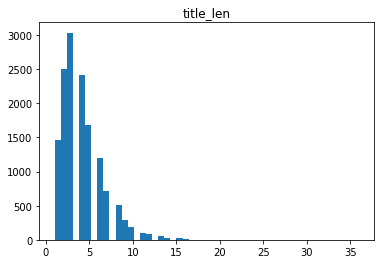

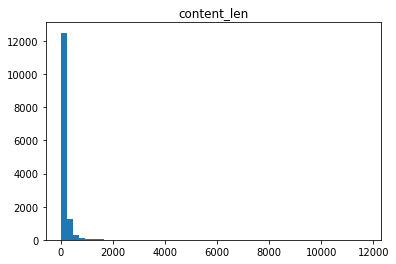

In [ ]:
for col in ['title_len', 'content_len']:
    plt.figure()
    plt.title(col)
    plt.hist(df[col], bins = 50)
    plt.plot()

$\longrightarrow$ Most of the poems have less than 10 words for the title and less than 500 words for the content.

### Vocabulary

In [ ]:
tokenizers = [TreebankWordTokenizer(), ToktokTokenizer()]
for tok in tqdm(tokenizers):
  print('Using tokenizer: %s' % (tok))
  arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
  # We flatten the list. We could use this : arr = reduce(add, arr)   but it would take too much time.
  arr = [ x for X in arr for x in X]
  # the set object transforms a list to the set of unique elements in the list :
  print('The 30 first tokens: %s' % (arr[:30]) )
  print("Vocabulary size: {0} with {1} tokenizer".format(len(set(arr)), tok))
  print('\n')

  0%|          | 0/2 [00:00<?, ?it/s]

Using tokenizer: <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7f6cb21e1cd0>
The 30 first tokens: ['A', 'lonely', 'heart', 'sets', 'the', 'table', 'but', 'is', 'she', 'a', 'Milly', ',', 'a', 'Betty', 'or', 'a', 'Mabel.', 'Tea', ',', 'coffee', ',', 'cakes', 'and', 'ale', 'but', 'outside', 'there', 'blows', 'a', 'gale.']
Vocabulary size: 116763 with <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7f6cb21e1cd0> tokenizer


Using tokenizer: <nltk.tokenize.toktok.ToktokTokenizer object at 0x7f6cb21e1d50>
The 30 first tokens: ['A', 'lonely', 'heart', 'sets', 'the', 'table', 'but', 'is', 'she', 'a', 'Milly', ',', 'a', 'Betty', 'or', 'a', 'Mabel.', 'Tea', ',', 'coffee', ',', 'cakes', 'and', 'ale', 'but', 'outside', 'there', 'blows', 'a', 'gale.']
Vocabulary size: 110166 with <nltk.tokenize.toktok.ToktokTokenizer object at 0x7f6cb21e1d50> tokenizer




### Zipf's law

Zipf's law is an empirical law that refers to the fact that for many types of textual data studied, the rank-frequency distribution is an inverse relation.
With $f_w$ the frenquency of the word $w$ and $k$ the frequency rank of entity $w$, we have :

$$ f_w(k) ~~ \alpha ~~ \dfrac{1}{k^{\theta}}$$

Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log(rank order) and log(frequency). Let's do it on our poetry content :

  0%|          | 0/2 [00:00<?, ?it/s]

Counter({',': 183547, 'the': 111126, 'and': 60127, 'of': 52246, 'to': 50147, 'I': 45367, 'a': 41851, 'in': 34886, 'And': 24784, 'is': 24761, 'you': 24673, ';': 22519, 'my': 20715, 'that': 20482, 'The': 19179, 'with': 18288, '!': 16677, 'it': 16499, 'for': 15482, "'s": 15461, 'me': 13888, 'on': 13216, 'not': 12973, 'be': 12474, 'all': 12388, '?': 12085, 'his': 11410, 'was': 11222, 'as': 10816, '.': 10609, 'your': 10552, 'are': 10478, 'her': 10035, 'from': 9433, 'he': 9260, 'we': 9078, '’': 8968, 'love': 8890, 'have': 8623, ':': 8146, 'will': 7865, 'by': 7851, 'this': 7793, 'they': 7756, 'at': 7748, 'But': 7576, 'so': 7489, 'their': 7206, 'life': 6979, 'one': 6956, 'To': 6946, 'or': 6935, 'A': 6886, '...': 6705, 'can': 6700, 'like': 6555, 'no': 6388, 'but': 6336, 'when': 5877, 'our': 5869, 'In': 5847, 'she': 5460, "'": 5431, 'what': 5422, 'do': 5401, '--': 5387, 'there': 5209, 'That': 5192, 'You': 4981, "''": 4913, 'It': 4901, "'d": 4897, 'He': 4601, 'who': 4588, 'For': 4578, "n't": 4464

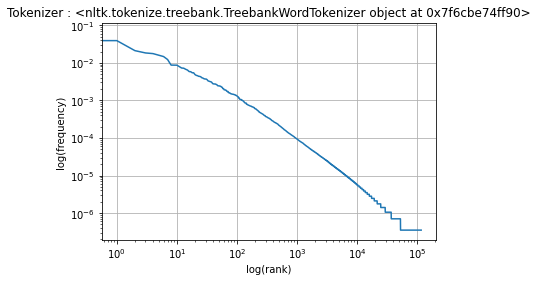

Counter({',': 183542, 'the': 111222, 'and': 60246, 'of': 52276, 'to': 50216, "'": 49550, 'I': 45672, 'a': 41928, 'in': 34939, 'And': 24920, 'you': 24799, 'is': 24323, ';': 22519, 'my': 20732, 'that': 20531, 's': 19319, 'The': 19296, 'with': 18324, '!': 16677, 'it': 16585, 'for': 15515, 'me': 14005, 'on': 13253, 'be': 12516, 'all': 12423, 'not': 12007, '?': 11459, 'his': 11421, 'was': 10990, 'as': 10844, 'your': 10559, 'are': 10425, '.': 10395, 'her': 10055, 'from': 9439, 'he': 9292, 'we': 9115, '’': 8968, 'love': 8947, 'have': 8579, ':': 8148, 'will': 7874, 'by': 7870, 'this': 7829, 'at': 7778, 'they': 7777, 'But': 7623, 'so': 7525, 'their': 7211, 'life': 7003, 'one': 6979, 'or': 6969, 'To': 6961, 'A': 6932, 't': 6677, 'like': 6586, 'can': 6511, 'no': 6413, 'but': 6392, '"': 5974, 'when': 5894, 'our': 5876, 'In': 5864, 'd': 5593, 'she': 5481, 'what': 5449, 'there': 5239, 'That': 5220, 'You': 5054, 'It': 4931, '--': 4862, 'He': 4640, 'For': 4602, 'who': 4595, 'God': 4492, 'out': 4453, '

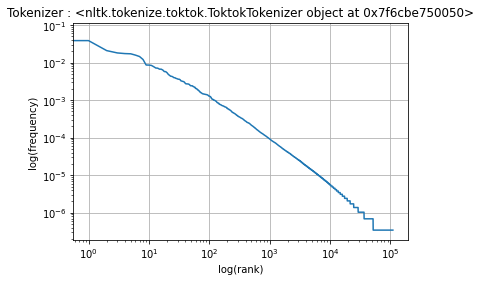

In [ ]:
for tok in tqdm(tokenizers):
  arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
  # We flatten the list. We could use this : arr = reduce(add, arr)   but it would take too much time.
  arr = [ x for X in arr for x in X]
  # We use reduce to concatenate all the lists in arr, but we don't use "set" 
  # so that we can count occurencies with a Counter object 
  c = Counter(arr)
  print(c)
  # Formating the counter object to a proper dataset
  d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
  d.columns=['word', 'occurences']
  # Computing frequencies instead of occurences
  nb_total = d.occurences.sum()
  d['freq'] = d.occurences.apply(lambda x: x/nb_total)
  # Sorting by frequency, most frequent word at the top of the df
  d = d.sort_values('freq', ascending=False)
  plt.figure()
  plt.grid()
  plt.xscale('log')  # Using log scale
  plt.yscale('log')  # Using log scale
  plt.xlabel('log(rank)')
  plt.ylabel('log(frequency)')
  plt.title("Tokenizer : {0}".format(tok))
  x = list(range(d.shape[0]))
  plt.plot(x, d.freq)
  plt.show()

$⟶$ Plots are almost linear : Zipf's law seems to be verified on our data.

### Wordcloud by theme

Rather than displaying the most common words, we can build the wordcloud inside for a given theme to see the most relevant words.

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def wordcloud_theme(df, theme):

  df_theme = df[df['theme'] == theme].copy()
  df_theme['tok'] = df_theme.content.apply(lambda x: tok.tokenize(x)).array
  df_theme['tok_cleaned'] = [' '.join(map(str, l)).lower() for l in df_theme['tok']]

  text = df_theme['tok_cleaned'].values
  stopwords = set(STOPWORDS)
  stopwords.add("")
  wordcloud = WordCloud(stopwords = stopwords).generate(str(text))

  plt.figure(figsize=(15,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

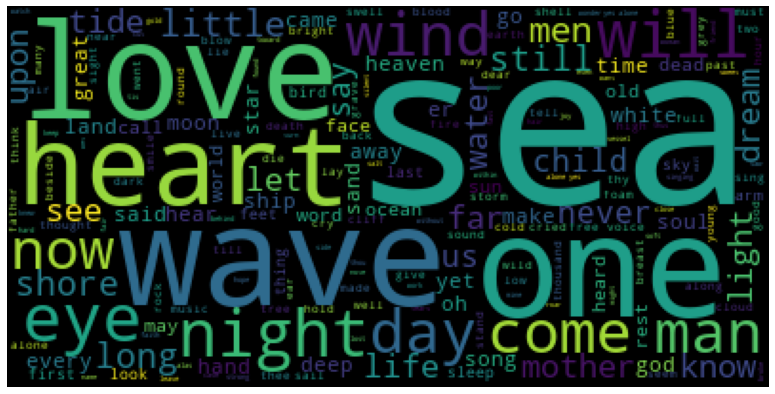

In [ ]:
wordcloud_theme(df,'sea')



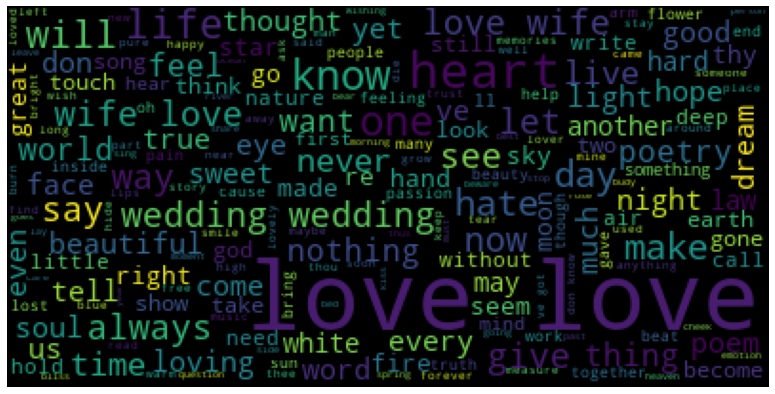

In [ ]:
wordcloud_theme(df,'love')

# Classification

In [3]:
tok = TreebankWordTokenizer()

In [4]:
df['tok'] = df.content.apply(lambda x: tok.tokenize(x)).array
df['tok'] = [' '.join(map(str, l)).lower() for l in df['tok']]

In [5]:
df['tok'].iloc[0]

"a lonely heart sets the table but is she a milly , a betty or a mabel. tea , coffee , cakes and ale but outside there blows a gale. sash cord windows rattling like chains , thunder and lighting tormenting her brains. a frail old lady who always lays up for tea but no one comes not even her family. as the rain pours down she gives a little frown as she looks at a photo in her wedding gown. a picture of love on her wedding day , a day she never wanted to go away.now all that 's forgotton as the clouds roll together , will her lonely heart stand up to this gale force weather. she draws the curtains and says goodnight to the storm then sits by the fire where its cosy and warm. no visitors tonight she says to the cat who lay curled up on the fireside mat. again she views her wedding day and asks the lord to show her the way.then she holds the cat to her lonely heart so that they will never be apart. the dear old lady died that night and the cat now sits on her burial site ."

In [ ]:
df[df['theme'] == 'butterfly'].sample(1)['tok'].values

array(["butterfly , oh butterfly , why do you hide in the shadows ? spread wide your wings , let your heart sing and come dance with me in the meadow butterfly , oh butterfly , why do you fear ? you 'll never stray , i 'll lead the way just follow the path , i 'll be near butterfly , oh butterfly , have you no hope ? drink of the sun , our life 's just begun thro time 's hills and valleys we 'll lope butterfly , oh butterfly , dare you to dream ? on our hearts we depend , shall we follow the wind and consign to the fates grander scheme ?"],
      dtype=object)

In [6]:
love_themes = ['love', 'passion', 'girl', 'baby', 'wedding', 'marriage', 'romance', 'lust', 'husband', 'kiss', 'together', 'romantic']
nature_themes = ['butterfly', 'rainbow', 'travel', 'spring', 'nature', 'sky', 'world', 'animal', 'river', 'winter',
                 'water', 'rain', 'hunting', 'weather', 'beach', 'summer', 'sun', 'snake', 'moon', 'ocean']
sadness_themes = ['lonely', 'sick', 'sorrow', 'fear', 'dark', 'lost', 'loss', 'hate', 'funeral', 'depression',
                  'suicide', 'poverty', 'murder', 'despair', 'anger', 'alone']

In [7]:
len(love_themes), len(nature_themes), len(sadness_themes)

(12, 20, 16)

In [8]:
def affect_label(theme):
  if theme in love_themes:
    return 0
  elif theme in nature_themes:
    return 1
  elif theme in sadness_themes:
    return 2
  else:
    return np.nan

df['label'] = df['theme'].apply(affect_label)

In [9]:
df

title                 author  \
0       A Lonely Heart In A Thunderstorm          sylviaspencer   
1                       A Lonely Weekend          sylviaspencer   
2                     Lonely In The Dark             nouriblack   
3                          Lonely Burial  Stephen Vincent Benet   
4      Filmscript For A Lonely Afternoon       Michael Shepherd   
...                                  ...                    ...   
14330                          War Music         Henry Van Dyke   
14331                              Music     Rainer Maria Rilke   
14332                 The Sound Of Music        Ravi Sathasivam   
14333                         Reed Music       Frederick Kesner   
14334                              Music           Wilfred Owen   

                                                 content   theme  \
0      A lonely heart sets the table but is she a Mil...  lonely   
1      How bright it is on a Friday, when I am away f...  lonely   
2      I am living in the darkness\nI feel so scared\...  lonely   
3      There were not many at that lonely place,\nWhe...  lonely   
4      walks into deserted playground\nindifferently,...  lonely   
...                                                  ...     ...   
14330  Break off! Dance no more!\nDanger is at the do...   music   
14331  Take me by the hand;\nit's so easy for you, An...   music   
14332  The sound of music gives us so much emotions\n...   music   
14333  Amber frosted reeds\nin the summer's wind\nswa...   music   
14334  I have been urged by earnest violins\nAnd drun...   music   

                                              file_title  \
0      LonelyPoemsALonelyHeartInAThunderstormPoembysy...   
1       LonelyPoemsALonelyWeekendPoembysylviaspencer.txt   
2         LonelyPoemsLonelyInTheDarkPoembynouriblack.txt   
3      LonelyPoemsLonelyBurialPoembyStephenVincentBen...   
4      LonelyPoemsFilmscriptForALonelyAfternoonPoemby...   
...                                                  ...   
14330           MusicPoemsWarMusicPoembyHenryVanDyke.txt   
14331          MusicPoemsMusicPoembyRainerMariaRilke.txt   
14332  MusicPoemsTheSoundOfMusicPoembyRaviSathasivam.txt   
14333       MusicPoemsReedMusicPoembyFrederickKesner.txt   
14334               MusicPoemsMusicPoembyWilfredOwen.txt   

                                                     tok  label  
0      a lonely heart sets the table but is she a mil...    2.0  
1      how bright it is on a friday , when i am away ...    2.0  
2      i am living in the darkness i feel so scared i...    2.0  
3      there were not many at that lonely place , whe...    2.0  
4      walks into deserted playground indifferently ,...    2.0  
...                                                  ...    ...  
14330  break off ! dance no more ! danger is at the d...    NaN  
14331  take me by the hand ; it 's so easy for you , ...    NaN  
14332  the sound of music gives us so much emotions a...    NaN  
14333  amber frosted reeds in the summer 's wind sway...    NaN  
14334  i have been urged by earnest violins and drunk...    NaN  

[14335 rows x 7 columns]

In [10]:
df_classif = df[df['label'].notna()][['tok', 'label']]
df_classif

tok  label
0      a lonely heart sets the table but is she a mil...    2.0
1      how bright it is on a friday , when i am away ...    2.0
2      i am living in the darkness i feel so scared i...    2.0
3      there were not many at that lonely place , whe...    2.0
4      walks into deserted playground indifferently ,...    2.0
...                                                  ...    ...
14131  i tell you that i see her still at the dark en...    2.0
14132  if god has been good enough to give you a poet...    2.0
14133  all alone , no one here not even a soul is 5ft...    2.0
14134  don ’ t leave me alone , this dark cold night ...    2.0
14135  the sorrow of riverside blossoms inexplicable ...    2.0

[4781 rows x 2 columns]

In [11]:
df_classif = df_classif.astype({'label':'int'})

In [12]:
df_classif['label'].value_counts()

1    1993
2    1590
0    1198
Name: label, dtype: int64

In [13]:
from datasets import *

train_dataset = Dataset.from_dict(df_classif)
poem_eval = datasets.DatasetDict({"train":train_dataset})

In [14]:
poem_eval

DatasetDict({
    train: Dataset({
        features: ['tok', 'label'],
        num_rows: 4781
    })
})

In [15]:
from sklearn.model_selection import train_test_split
# we retrieve a list of indices (required for the .select() method of the hugging face dataset object - which is not a dictionary -)
indices = [i for i in range(len(poem_eval['train']))]
# use scikit learn to split the indices into subsets: ~67% train, ~16 % val, ~16% test
train_indices, other_indices, _, _ = train_test_split(indices, indices, test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, test_size=0.5, random_state=42)

In [16]:
print(len(train_indices), len(val_indices), len(test_indices))

3203 789 789


In [17]:
poem_eval['validation'] = poem_eval['train'].select(val_indices)
poem_eval['test'] = poem_eval['train'].select(test_indices)
poem_eval['train'] = poem_eval['train'].select(train_indices)

In [18]:
poem_eval['train']['tok'][:3]

['spinning faster and faster , spiraling down , down , depression creates a suffocating heaviness which consumes and smothers your entire being. as i recall this space in time , it seems as though viewing an experience that belongs to a stranger. my physical body defeated , so tired there is no movement. eratic thought patterns that make no sense. who is controlling these thoughts ? my mind is in control , which now belongs to the very dark powerful emotion of depression. this emotion gathers together , confusion , negativity , loss , misery , self hatred , guilt , and doubt , all joining forces and circling faster , causing dizziness and taking me down to a cold , dark place full of sadness. this sadness so overwhelming it comes crashing , over and over like pounding waves , its too dark to see anything , the next wave crashes over with no time for a breath before the next wave floods tears that fall as though they will never stop falling. nothing makes any sense - i am lost , it is d

In [19]:
poem_eval['train']['label'][:3]

[2, 0, 1]

In [20]:
# # keep in mind we represent labels as indices
print(Counter(poem_eval['test']['label']))

Counter({1: 334, 2: 269, 0: 186})


### Import pre-trained embeddings

In [21]:
# fasttext vectors can be imported through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='en')

In [22]:
pretrained_vectors.vectors.size()

torch.Size([2519370, 300])

In [23]:
for i, (key, value) in enumerate(pretrained_vectors.stoi.items()):
  print('token:', key, '| indice:', value)
  # we only look at the first 5 elements
  if i > 5: break

token: , | indice: 0
token: . | indice: 1
token: the | indice: 2
token: </s> | indice: 3
token: of | indice: 4
token: - | indice: 5
token: in | indice: 6


In [24]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)

#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

In [25]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=40):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['tok'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['tok']]
  res['label'] = entries['label']
  return res

poem_eval['train'] = poem_eval['train'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [26]:
poem_eval['validation'] = poem_eval['validation'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
poem_eval['test'] = poem_eval['test'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
from torch.utils.data import Dataset

class PoemDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "tok": np.array(self.data[idx]['tok']),
          "label": np.array(self.data[idx]['label'])
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

In [30]:
# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(PoemDataset(poem_eval['train'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(PoemDataset(poem_eval['validation'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(PoemDataset(poem_eval['test'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [31]:
next(iter(train_loader))['tok'].shape

torch.Size([64, 200])

### Pytorch Model

In [32]:
class PoemModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(PoemModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x = self.ebd(x)
        x = x.mean(1)
        h = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [33]:
sizes = next(iter(train_loader))['tok'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 200


In [34]:
import torch.nn as nn
import torch.nn.functional as F

hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 types of poems
# we instanciate the model
poem_model = PoemModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [35]:
# we can look at the model 
poem_model

PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [36]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', torch.cuda.get_device_name(0))
else:
  device = 'cpu'
  print('DEVICE = ', 'CPU')
poem_model.to(device)

DEVICE =  CPU


PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [37]:
next(poem_model.parameters()).is_cuda

False

In [38]:
from torchinfo import summary
# to prevent some bugs, move the model to CPU, then move it back to cuda (using the device variable)
# with verbose set to 2 we have more information. however a bug makes it print twice...
print(summary(poem_model.to('cpu'), (batchsize, inputdim), dtypes=['torch.IntTensor'], device='cpu', verbose=2))
poem_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
PoemModel                                --                        --
├─Embedding: 1-1                         [64, 200, 300]            (755,811,000)
│    └─weight                                                      └─755,811,000
├─Linear: 1-2                            [64, 300]                 90,300
│    └─weight                                                      ├─90,000
│    └─bias                                                        └─300
├─Linear: 1-3                            [64, 3]                   903
│    └─weight                                                      ├─900
│    └─bias                                                        └─3
├─Softmax: 1-4                           [64, 3]                   --
Total params: 755,902,203
Trainable params: 91,203
Non-trainable params: 755,811,000
Total mult-adds (G): 48.38
Input size (MB): 0.05
Forward/backward pass size (MB): 30.88
Params size 

PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [39]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'tok': batch['tok'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['tok'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (str(ep),args['max_eps'] , 'Training', 'loss', sum(loss_it)/len(loss_it), 'acc', sum(acc_it) / len(acc_it)))


In [40]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'tok': batch['tok'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['tok'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( target, 'loss', sum(loss_it)/len(loss_it), 'acc', sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [41]:
import torch.optim as optim

def run_epochs(model, args):

  args['device'] =device
  # if args['cuda'] != -1:
  #     model.cuda(args['cuda'])
  #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #     args['device'] = device
  #     print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [42]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 30, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
poem_model = PoemModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(poem_model, args)

device cpu


Epoch 0::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/30 : Training : (loss 1.0909560418128967) (acc 0.4103125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.072872281074524) (acc 0.4830729166666667)


Epoch 1::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/30 : Training : (loss 1.063716208934784) (acc 0.4884375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0390804012616475) (acc 0.5208333333333334)


Epoch 2::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/30 : Training : (loss 1.043544228076935) (acc 0.5134375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0286871095498402) (acc 0.5130208333333334)


Epoch 3::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/30 : Training : (loss 1.0310797917842864) (acc 0.528125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0124447643756866) (acc 0.5403645833333334)


Epoch 4::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/30 : Training : (loss 1.0189737963676453) (acc 0.5309375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0269093463818233) (acc 0.4921875)


Epoch 5::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/30 : Training : (loss 1.005130627155304) (acc 0.545625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0152329951524734) (acc 0.50390625)


Epoch 6::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/30 : Training : (loss 0.9996113741397857) (acc 0.5446875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9934674650430679) (acc 0.54296875)


Epoch 7::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/30 : Training : (loss 0.9921612441539764) (acc 0.556875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.980694924791654) (acc 0.55078125)


Epoch 8::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/30 : Training : (loss 0.9843548166751862) (acc 0.5621875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.003030036886533) (acc 0.5260416666666666)


Epoch 9::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/30 : Training : (loss 0.980242725610733) (acc 0.5675)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9771551638841629) (acc 0.54296875)


Epoch 10::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/30 : Training : (loss 0.9774111211299896) (acc 0.570625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9828051129976908) (acc 0.5416666666666666)


Epoch 11::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/30 : Training : (loss 0.9707463181018829) (acc 0.5778125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9856196443239847) (acc 0.5364583333333334)


Epoch 12::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/30 : Training : (loss 0.9662270593643189) (acc 0.580625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9720499217510223) (acc 0.5546875)


Epoch 13::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/30 : Training : (loss 0.9690521740913391) (acc 0.5734375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9672706723213196) (acc 0.5611979166666666)


Epoch 14::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/30 : Training : (loss 0.9654522788524628) (acc 0.5846875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9645778189102808) (acc 0.5638020833333334)


Epoch 15::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/30 : Training : (loss 0.9601118338108062) (acc 0.586875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9889136552810669) (acc 0.5221354166666666)


Epoch 16::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/30 : Training : (loss 0.9564596486091613) (acc 0.58875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9621093918879827) (acc 0.55859375)


Epoch 17::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/30 : Training : (loss 0.9529774296283722) (acc 0.5946875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0066880484422047) (acc 0.4934895833333333)


Epoch 18::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/30 : Training : (loss 0.9510161054134368) (acc 0.5978125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9575977573792139) (acc 0.5611979166666666)


Epoch 19::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/30 : Training : (loss 0.9456387591362) (acc 0.603125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9602579226096472) (acc 0.5716145833333334)


Epoch 20::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/30 : Training : (loss 0.9431774938106536) (acc 0.6028125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9803305417299271) (acc 0.5533854166666666)


Epoch 21::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/30 : Training : (loss 0.9428778207302093) (acc 0.5959375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9778392215569814) (acc 0.5520833333333334)


Epoch 22::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/30 : Training : (loss 0.9409213733673095) (acc 0.6071875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9703155507644018) (acc 0.5572916666666666)


Epoch 23::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/30 : Training : (loss 0.936394716501236) (acc 0.61125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9464112917582194) (acc 0.5859375)


Epoch 24::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/30 : Training : (loss 0.935466046333313) (acc 0.613125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9694614559412003) (acc 0.546875)


Epoch 25::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/30 : Training : (loss 0.9327299475669861) (acc 0.6184375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9563924719889959) (acc 0.5677083333333334)


Epoch 26::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/30 : Training : (loss 0.9332405960559845) (acc 0.6171875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9480991860230764) (acc 0.5716145833333334)


Epoch 27::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/30 : Training : (loss 0.9337896656990051) (acc 0.6146875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9509979436794916) (acc 0.5963541666666666)


Epoch 28::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/30 : Training : (loss 0.9286316680908203) (acc 0.620625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9515657325585684) (acc 0.578125)


Epoch 29::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/30 : Training : (loss 0.9262145292758942) (acc 0.628125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9452583740154902) (acc 0.58984375)


In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

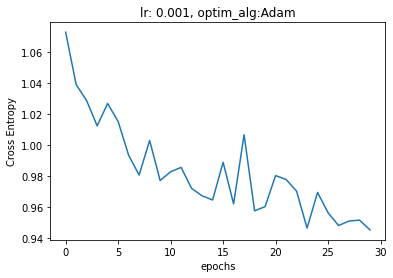

In [45]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

In [46]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, poem_model)

test::   0%|          | 0/12 [00:00<?, ?it/s]

test : (loss 0.9663732349872589) (acc 0.5611979166666666)


In [47]:
from termcolor import colored

# let's look at the first ten predictions
for t, p in zip(trues[:10], preds[:10]):
  correct = colored('Correct', 'green') if t == p else colored('Mistake', 'red')
  print('true', t, 'predicted', p, correct)

true 0 predicted 2 Mistake
true 1 predicted 1 Correct
true 1 predicted 1 Correct
true 2 predicted 2 Correct
true 0 predicted 1 Mistake
true 2 predicted 2 Correct
true 0 predicted 2 Mistake
true 2 predicted 2 Correct
true 2 predicted 0 Mistake
true 1 predicted 0 Mistake


In [48]:
names = ["💕", "🌄", "😥"]

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

           💕       0.46      0.56      0.51       183
           🌄       0.61      0.67      0.64       323
           😥       0.58      0.43      0.49       262

    accuracy                           0.56       768
   macro avg       0.55      0.55      0.55       768
weighted avg       0.57      0.56      0.56       768



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127748 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128149 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127748 missing from current font.
  font.set_text(s, 0, flags=flags)


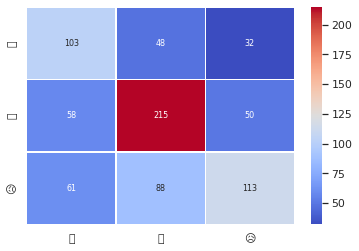

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()